In [1]:
import socket
import spynnaker8 as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from numpy import genfromtxt

import sys
sys.path.insert(1, '../../miscelaneous')
from spinnorse_tools import fetch_files, plot_iho

Detected PyNN version 0.9.4 and Neo version 0.6.1


In [2]:
dt = 1           # (ms) simulation timestep

cell_params = {'tau_m': 20.0,
               'tau_syn_E': 5.0,
               'tau_syn_I': 5.0,
               'v_rest': -65.0,
               'v_reset': -65.0,
               'v_thresh': -50.0,
               'tau_refrac': 0.0, # 0.1 originally
               'cm': 1,
               'i_offset': 0.0
               }

w = 1

2021-01-05 15:37:25 INFO: Read cfg files: /home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/jprb/.spynnaker.cfg
2021-01-05 15:37:25 INFO: Will search these locations for binaries: /home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2021-01-05 15:37:25 INFO: Setting time scale factor to 1.
2021-01-05 15:37:25 INFO: Setting machine time step to 1000 micro-seconds.
2021-01-05 15:37:25 INFO: Simulating for 200 1.0ms timesteps using a hardware timestep of 1000us
2021-01-05 15:37:25 INFO: Starting execution process
2021-01-05 15:37:25 INFO: Creating transceiver for 192.168.240.1
2021-01-05 15:37:25 INFO: Working out if machine is booted
2021-01-05 15:37:25 INFO: Found board with version [Version: SC&MP 3.2.5 at SpiNNaker:0:0:0 (built Thu Aug  1 10:15:06

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:37:26 INFO: Time 0:00:00.033097 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:37:26 INFO: Time 0:00:00.035317 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:37:26 INFO: Time 0:00:00.044331 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:37:26 INFO: Time 0:00:00.007828 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:37:26 INFO: Time 0:00:00.007126 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%            

2021-01-05 15:37:47 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:37:47 INFO: Time 0:00:00.054032 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:37:47 INFO: Time 0:00:00.026589 taken by ChipRuntimeUpdater
2021-01-05 15:37:47 INFO: Time 0:00:00.000200 taken by DatabaseInterface
2021-01-05 15:37:47 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:37:47 INFO: Time 0:00:00.000545 taken by NotificationProtocol
2021-01-05 15:37:47 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:37:47 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:37:47 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...



2021-01-05 15:38:09 INFO: Time 0:00:00.030320 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:38:09 INFO: Time 0:00:00.037214 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:38:09 INFO: Time 0:00:00.013013 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:38:09 INFO: Time 0:00:00.003957 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:38:09 INFO: Time 0:00:00.048773 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%         

Updating run time
|0%                          50%                         100%|
2021-01-05 15:38:30 INFO: Time 0:00:00.029937 taken by ChipRuntimeUpdater
2021-01-05 15:38:30 INFO: Time 0:00:00.000159 taken by DatabaseInterface
2021-01-05 15:38:30 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:38:30 INFO: Time 0:00:00.000976 taken by NotificationProtocol
2021-01-05 15:38:30 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:38:30 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:38:30 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:38:30 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:38:30 INFO: Application started; waiting 0.30000000000000004s f

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:38:51 INFO: Time 0:00:00.026704 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:38:51 INFO: Time 0:00:00.047478 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:38:51 INFO: Time 0:00:00.006965 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:38:51 INFO: Time 0:00:00.006490 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:38:52 INFO: Time 0:00:00.050839 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%          

Updating run time
|0%                          50%                         100%|
2021-01-05 15:39:15 INFO: Time 0:00:00.026727 taken by ChipRuntimeUpdater
2021-01-05 15:39:15 INFO: Time 0:00:00.000166 taken by DatabaseInterface
2021-01-05 15:39:15 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:39:15 INFO: Time 0:00:00.000826 taken by NotificationProtocol
2021-01-05 15:39:15 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:39:15 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:39:15 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:39:15 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:39:15 INFO: Application started; waiting 0.30000000000000004s f

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:39:36 INFO: Time 0:00:00.039481 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:39:36 INFO: Time 0:00:00.039178 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:39:36 INFO: Time 0:00:00.007203 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:39:36 INFO: Time 0:00:00.005334 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:39:36 INFO: Time 0:00:00.043883 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%          

2021-01-05 15:39:58 INFO: Time 0:00:00.040080 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:39:58 INFO: Time 0:00:00.028258 taken by ChipRuntimeUpdater
2021-01-05 15:39:58 INFO: Time 0:00:00.000148 taken by DatabaseInterface
2021-01-05 15:39:58 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:39:58 INFO: Time 0:00:00.000621 taken by NotificationProtocol
2021-01-05 15:39:58 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:39:58 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:39:58 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:39:58 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start *

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...



2021-01-05 15:40:19 INFO: Time 0:00:00.039194 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:40:19 INFO: Time 0:00:00.037897 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:40:19 INFO: Time 0:00:00.039282 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:40:19 INFO: Time 0:00:00.008456 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:40:19 INFO: Time 0:00:00.005614 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%           

2021-01-05 15:40:41 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:40:41 INFO: Time 0:00:00.052445 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:40:41 INFO: Time 0:00:00.028423 taken by ChipRuntimeUpdater
2021-01-05 15:40:41 INFO: Time 0:00:00.000240 taken by DatabaseInterface
2021-01-05 15:40:41 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:40:41 INFO: Time 0:00:00.000869 taken by NotificationProtocol
2021-01-05 15:40:41 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:40:41 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:40:41 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:41:02 INFO: Time 0:00:00.025469 taken by MallocBasedChipIDAllocator
Inserting extra monitors into graphs
|0%                          50%                         100%|
2021-01-05 15:41:02 INFO: Time 0:00:00.029614 taken by InsertExtraMonitorVerticesToGraphs
Writing the board chip report
|0%                          50%                         100%|
2021-01-05 15:41:02 INFO: Time 0:00:00.003611 taken by BoardChipReport
Filtering edges
|0%                          50%                         100%|
2021-01-05 15:41:02 INFO: Time 0:00:00.027685 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:41:02 INFO: Time 0:00:00.032784 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:41:02 INFO: Time 0:00:00.040537 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables f

2021-01-05 15:41:27 INFO: Time 0:00:00.010599 taken by RoutingTableFromMachineReport
Generating compressed router table report
|0%                          50%                         100%|
2021-01-05 15:41:27 INFO: Time 0:00:00.008181 taken by compressedRoutingTableReports
Generating comparison of router table report
|0%                          50%                         100%|
2021-01-05 15:41:27 INFO: Time 0:00:00.008142 taken by comparisonOfRoutingTablesReport
2021-01-05 15:41:27 INFO: Running for 1 steps for a total of 200.0ms
2021-01-05 15:41:27 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:41:27 INFO: Time 0:00:00.046563 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:41:27 INFO: Time 0:00:00.028571 taken by ChipRuntimeUpdater
2021-01-05 15:41:27 INFO: Time 0:00:00.000142 taken by DatabaseInterface
2021-01-05 15:41:27 INFO

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:41:48 INFO: Time 0:00:00.027847 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:41:48 INFO: Time 0:00:00.031620 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:41:48 INFO: Time 0:00:00.050802 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:41:48 INFO: Time 0:00:00.004771 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:41:48 INFO: Time 0:00:00.010988 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%            

2021-01-05 15:42:10 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:42:10 INFO: Time 0:00:00.047918 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:42:10 INFO: Time 0:00:00.030586 taken by ChipRuntimeUpdater
2021-01-05 15:42:10 INFO: Time 0:00:00.000215 taken by DatabaseInterface
2021-01-05 15:42:10 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:42:10 INFO: Time 0:00:00.001266 taken by NotificationProtocol
2021-01-05 15:42:10 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:42:10 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:42:10 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...



2021-01-05 15:42:31 INFO: Time 0:00:00.029110 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:42:31 INFO: Time 0:00:00.031823 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:42:32 INFO: Time 0:00:00.055026 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:42:32 INFO: Time 0:00:00.006897 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:42:32 INFO: Time 0:00:00.006675 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%           

2021-01-05 15:42:56 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:42:56 INFO: Time 0:00:00.059628 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:42:56 INFO: Time 0:00:00.030148 taken by ChipRuntimeUpdater
2021-01-05 15:42:56 INFO: Time 0:00:00.000168 taken by DatabaseInterface
2021-01-05 15:42:56 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:42:56 INFO: Time 0:00:00.001065 taken by NotificationProtocol
2021-01-05 15:42:56 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:42:56 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:42:56 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:43:18 INFO: Time 0:00:00.042558 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:43:18 INFO: Time 0:00:00.055885 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:43:18 INFO: Time 0:00:00.009290 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:43:18 INFO: Time 0:00:00.004475 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:43:18 INFO: Time 0:00:00.056451 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%          

2021-01-05 15:43:39 INFO: Time 0:00:00.056408 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:43:39 INFO: Time 0:00:00.030451 taken by ChipRuntimeUpdater
2021-01-05 15:43:39 INFO: Time 0:00:00.000229 taken by DatabaseInterface
2021-01-05 15:43:39 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:43:39 INFO: Time 0:00:00.000822 taken by NotificationProtocol
2021-01-05 15:43:39 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:43:40 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:43:40 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:43:40 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start *

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:44:01 INFO: Time 0:00:00.031239 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:44:01 INFO: Time 0:00:00.033239 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:44:01 INFO: Time 0:00:00.048186 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:44:01 INFO: Time 0:00:00.007406 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:44:01 INFO: Time 0:00:00.005962 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%            

2021-01-05 15:44:25 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:44:26 INFO: Time 0:00:00.052576 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:44:26 INFO: Time 0:00:00.029918 taken by ChipRuntimeUpdater
2021-01-05 15:44:26 INFO: Time 0:00:00.000218 taken by DatabaseInterface
2021-01-05 15:44:26 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:44:26 INFO: Time 0:00:00.000625 taken by NotificationProtocol
2021-01-05 15:44:26 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:44:26 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:44:26 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


=====
2021-01-05 15:44:47 INFO: Time 0:00:00.032226 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:44:47 INFO: Time 0:00:00.043925 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:44:47 INFO: Time 0:00:00.044897 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:44:47 INFO: Time 0:00:00.009097 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:44:47 INFO: Time 0:00:00.005817 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%      

2021-01-05 15:45:09 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:45:09 INFO: Time 0:00:00.048946 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:45:09 INFO: Time 0:00:00.031079 taken by ChipRuntimeUpdater
2021-01-05 15:45:09 INFO: Time 0:00:00.000179 taken by DatabaseInterface
2021-01-05 15:45:09 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:45:09 INFO: Time 0:00:00.001686 taken by NotificationProtocol
2021-01-05 15:45:09 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:45:09 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:45:09 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:45:30 INFO: Time 0:00:00.031229 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:45:30 INFO: Time 0:00:00.036610 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:45:30 INFO: Time 0:00:00.044304 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:45:30 INFO: Time 0:00:00.005936 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:45:30 INFO: Time 0:00:00.003178 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%            

2021-01-05 15:45:54 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:45:54 INFO: Time 0:00:00.045974 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:45:54 INFO: Time 0:00:00.029477 taken by ChipRuntimeUpdater
2021-01-05 15:45:54 INFO: Time 0:00:00.000184 taken by DatabaseInterface
2021-01-05 15:45:54 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:45:54 INFO: Time 0:00:00.000842 taken by NotificationProtocol
2021-01-05 15:45:54 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:45:54 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:45:54 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:46:15 INFO: Time 0:00:00.028641 taken by GraphEdgeFilter
Placing graph vertices
|0%                          50%                         100%|
2021-01-05 15:46:15 INFO: Time 0:00:00.034873 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:46:15 INFO: Time 0:00:00.040623 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:46:15 INFO: Time 0:00:00.008424 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:46:15 INFO: Time 0:00:00.005705 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%            

2021-01-05 15:46:40 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2021-01-05 15:46:40 INFO: Time 0:00:00.049719 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:46:40 INFO: Time 0:00:00.032229 taken by ChipRuntimeUpdater
2021-01-05 15:46:40 INFO: Time 0:00:00.000191 taken by DatabaseInterface
2021-01-05 15:46:40 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:46:40 INFO: Time 0:00:00.000962 taken by NotificationProtocol
2021-01-05 15:46:40 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:46:40 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:46:40 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:47:01 INFO: Time 0:00:00.035180 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:47:01 INFO: Time 0:00:00.038031 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:47:01 INFO: Time 0:00:00.008148 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:47:01 INFO: Time 0:00:00.006612 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:47:01 INFO: Time 0:00:00.048807 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%          

2021-01-05 15:47:23 INFO: Time 0:00:00.048206 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:47:23 INFO: Time 0:00:00.028938 taken by ChipRuntimeUpdater
2021-01-05 15:47:23 INFO: Time 0:00:00.000180 taken by DatabaseInterface
2021-01-05 15:47:23 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:47:23 INFO: Time 0:00:00.000746 taken by NotificationProtocol
2021-01-05 15:47:23 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:47:23 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:47:23 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:47:23 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start *

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:47:45 INFO: Time 0:00:00.024968 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:47:45 INFO: Time 0:00:00.048726 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:47:45 INFO: Time 0:00:00.013235 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:47:45 INFO: Time 0:00:00.005547 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:47:45 INFO: Time 0:00:00.047894 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%          

2021-01-05 15:48:08 INFO: Time 0:00:00.045547 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:48:08 INFO: Time 0:00:00.027194 taken by ChipRuntimeUpdater
2021-01-05 15:48:08 INFO: Time 0:00:00.000147 taken by DatabaseInterface
2021-01-05 15:48:08 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:48:08 INFO: Time 0:00:00.000672 taken by NotificationProtocol
2021-01-05 15:48:08 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:48:08 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:48:08 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:48:08 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start *

['/home/jprb/myspin/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jprb/myspin/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jprb/.spynnaker.cfg']
0 Running simulation...


2021-01-05 15:48:29 INFO: Time 0:00:00.032857 taken by OneToOnePlacer
Inserting edges between vertices which require FR speed up functionality.
|0%                          50%                         100%|
2021-01-05 15:48:29 INFO: Time 0:00:00.056500 taken by InsertEdgesToExtraMonitorFunctionality
Generating routing tables for data in system processes
|0%                          50%                         100%|
2021-01-05 15:48:29 INFO: Time 0:00:00.006035 taken by DataInMulticastRoutingGenerator
Generating fixed router routes
|0%                          50%                         100%|
2021-01-05 15:48:29 INFO: Time 0:00:00.006830 taken by FixedRouteRouter
Generating placement report
|0%                          50%                         100%|
Generating placement by core report
|0%                          50%                         100%|
2021-01-05 15:48:29 INFO: Time 0:00:00.045299 taken by PlacerReportWithApplicationGraph
Routing
|0%                          50%          

2021-01-05 15:48:54 INFO: Time 0:00:00.052628 taken by SdramUsageReportPerChip
Updating run time
|0%                          50%                         100%|
2021-01-05 15:48:54 INFO: Time 0:00:00.028703 taken by ChipRuntimeUpdater
2021-01-05 15:48:54 INFO: Time 0:00:00.000184 taken by DatabaseInterface
2021-01-05 15:48:54 INFO: ** Notifying external sources that the database is ready for reading **
2021-01-05 15:48:54 INFO: Time 0:00:00.000631 taken by NotificationProtocol
2021-01-05 15:48:54 INFO: *** Running simulation... *** 
Loading buffers
|0%                          50%                         100%|
2021-01-05 15:48:54 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start **
2021-01-05 15:48:54 INFO: ** Sending start / resume message to external sources to state the simulation has started or resumed. **
2021-01-05 15:48:54 INFO: ** Awaiting for a response from an external source to state its ready for the simulation to start *

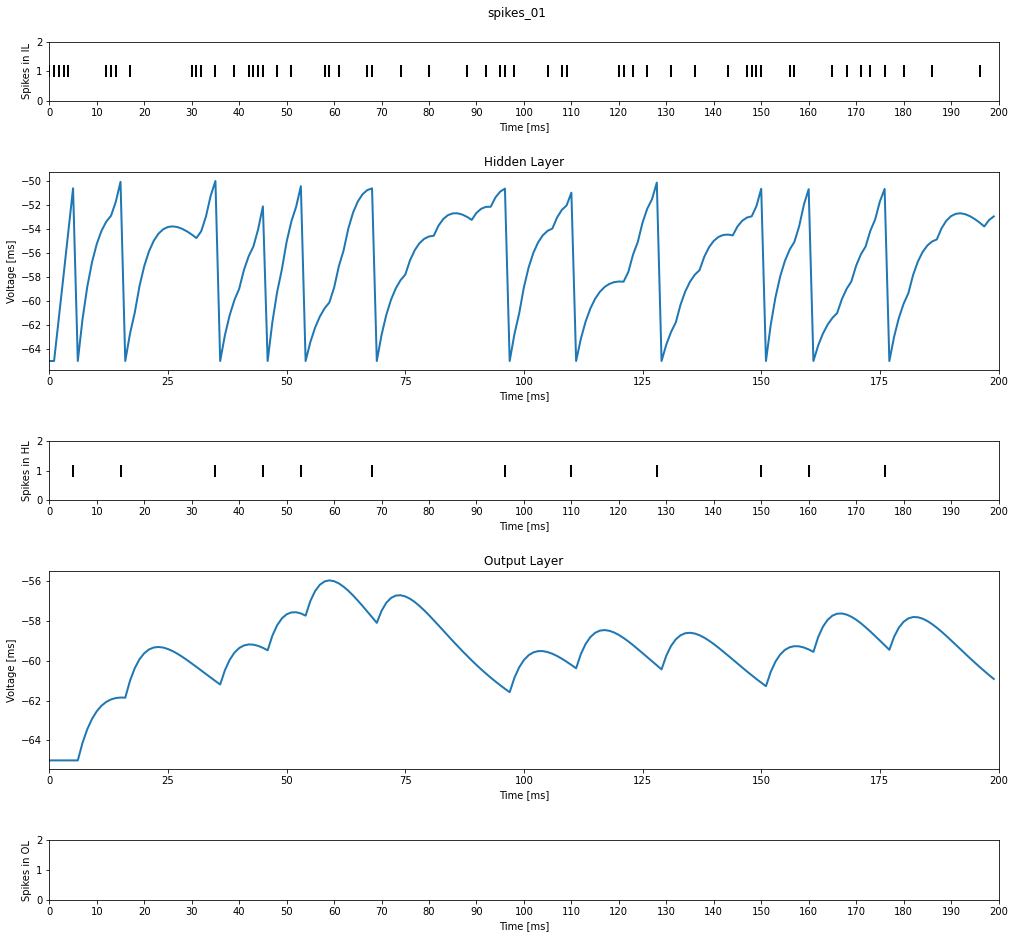

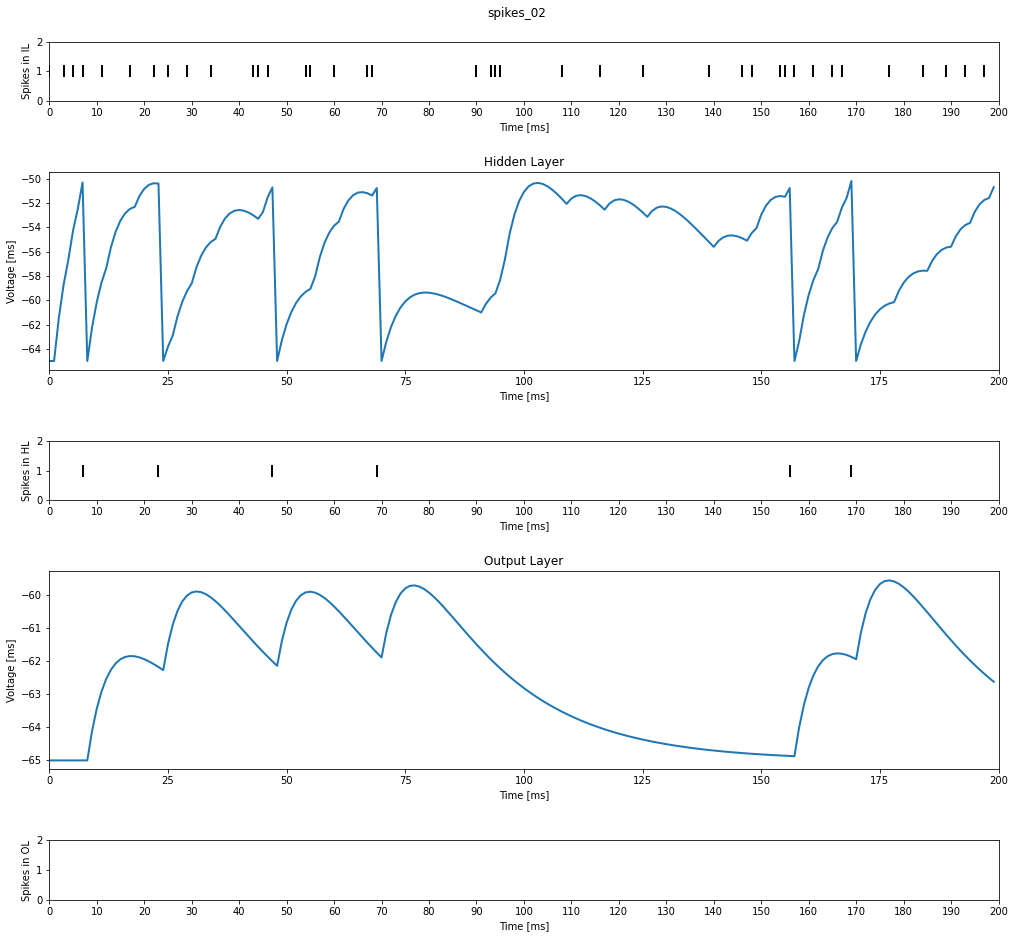

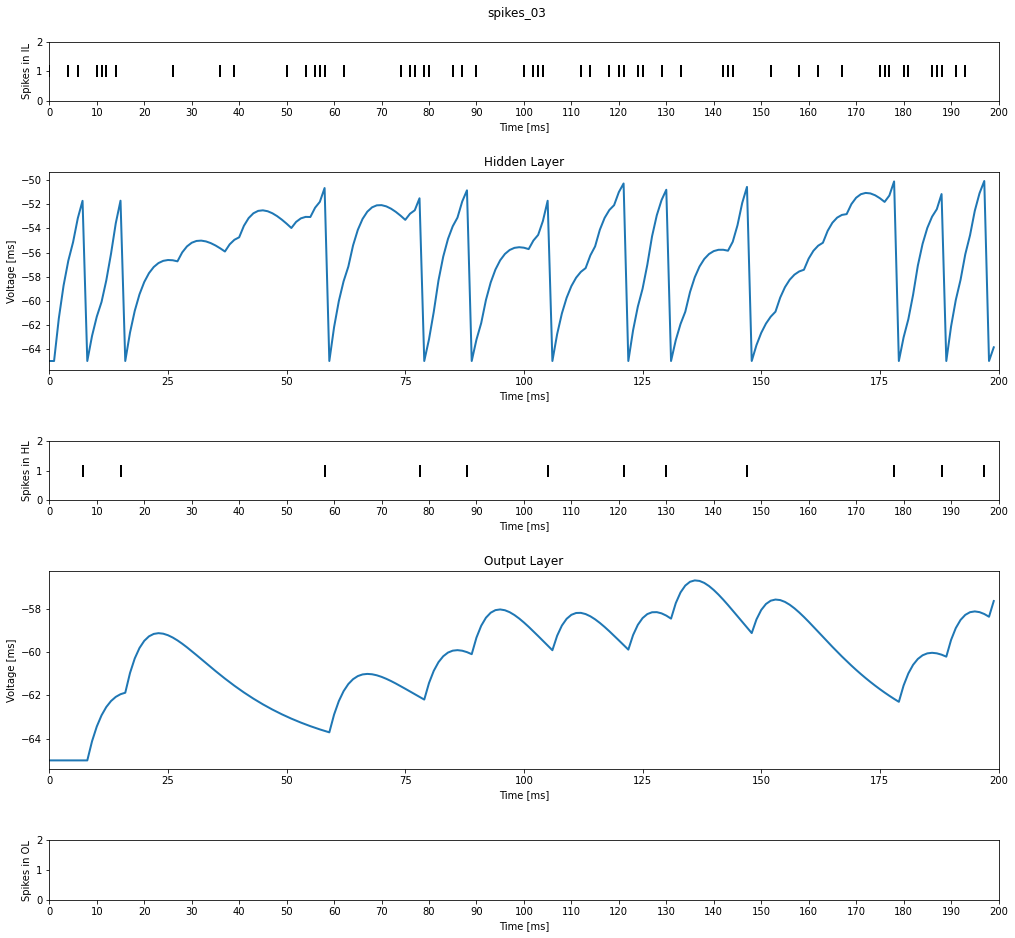

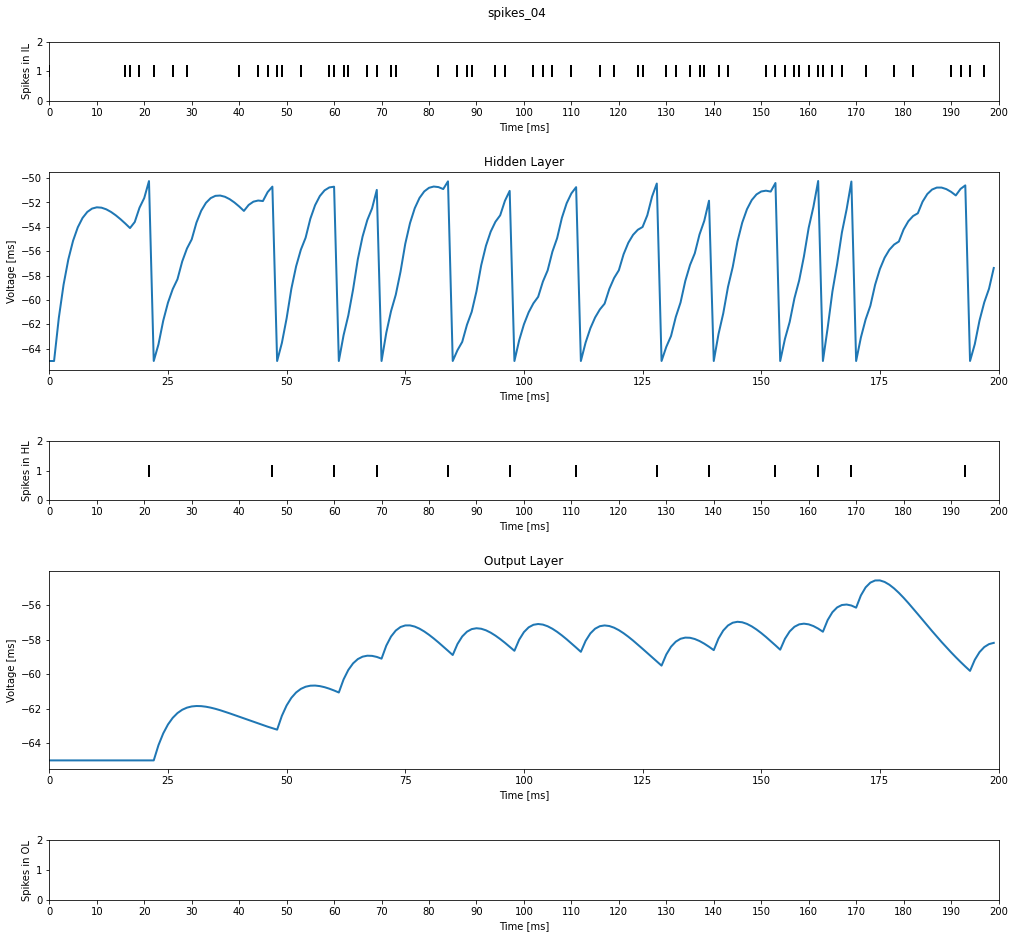

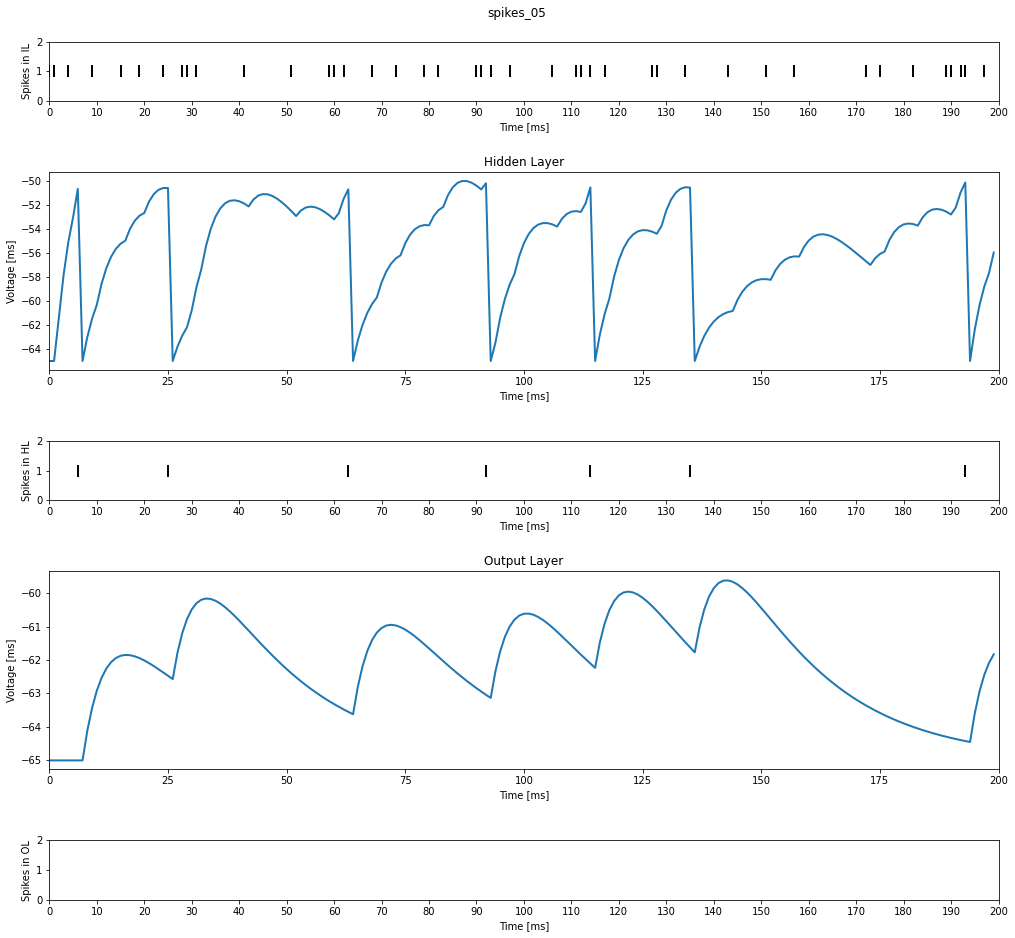

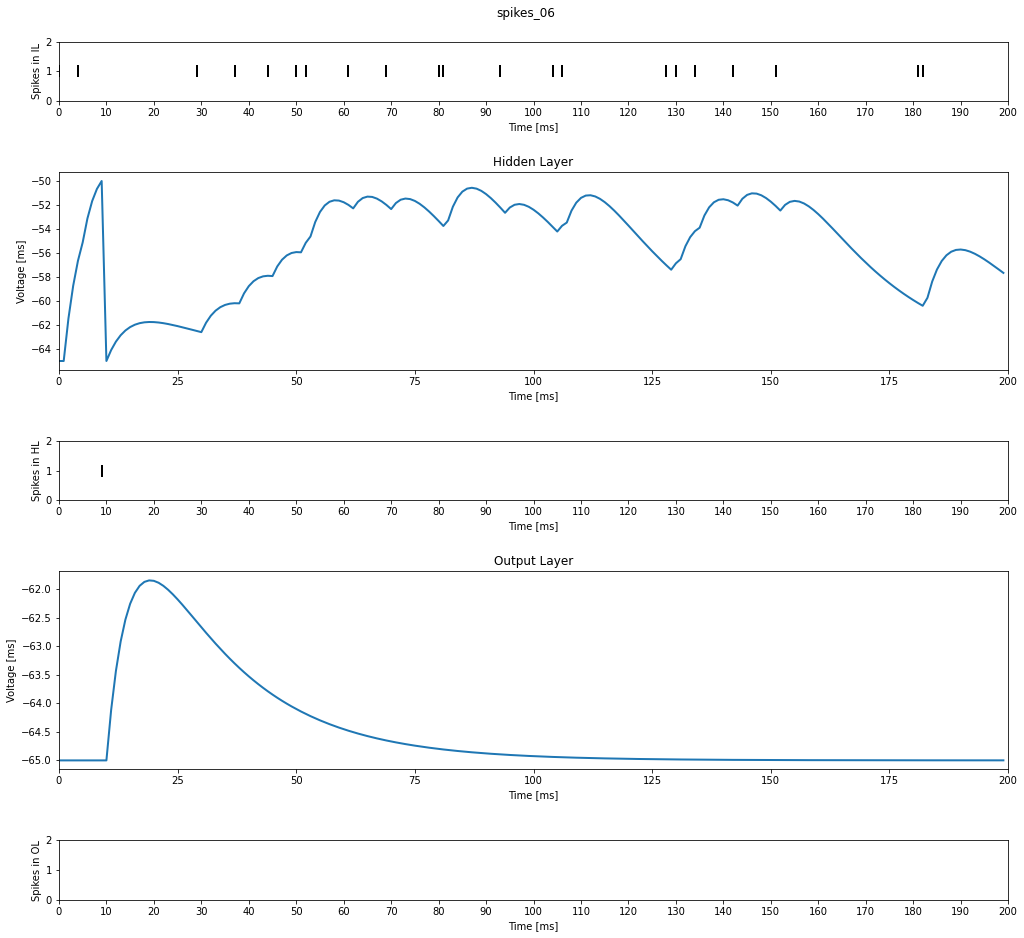

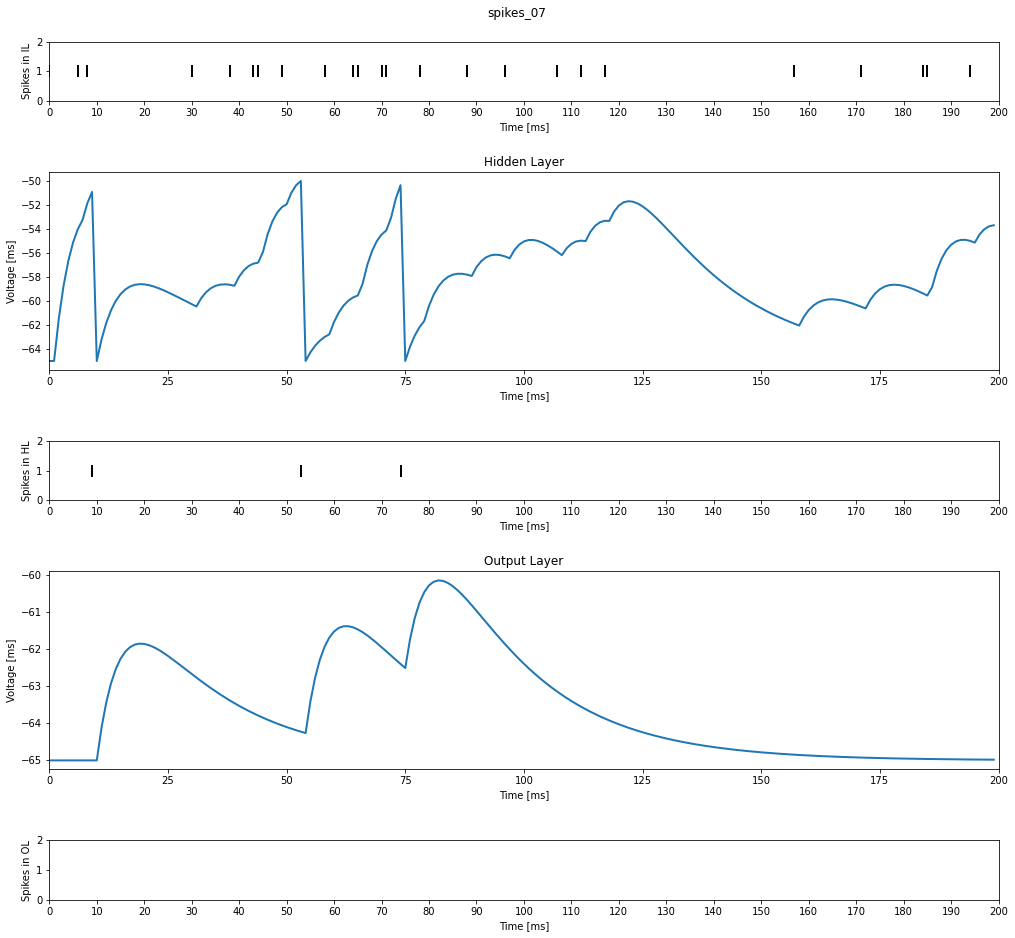

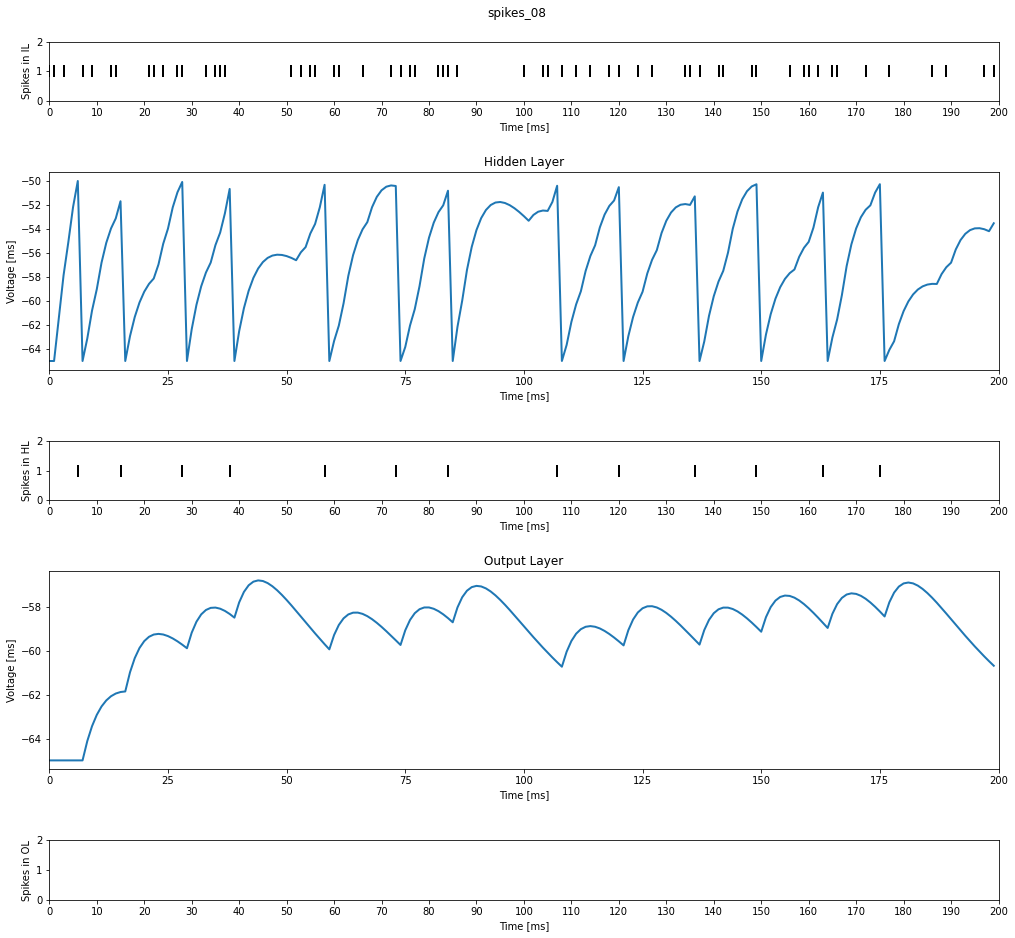

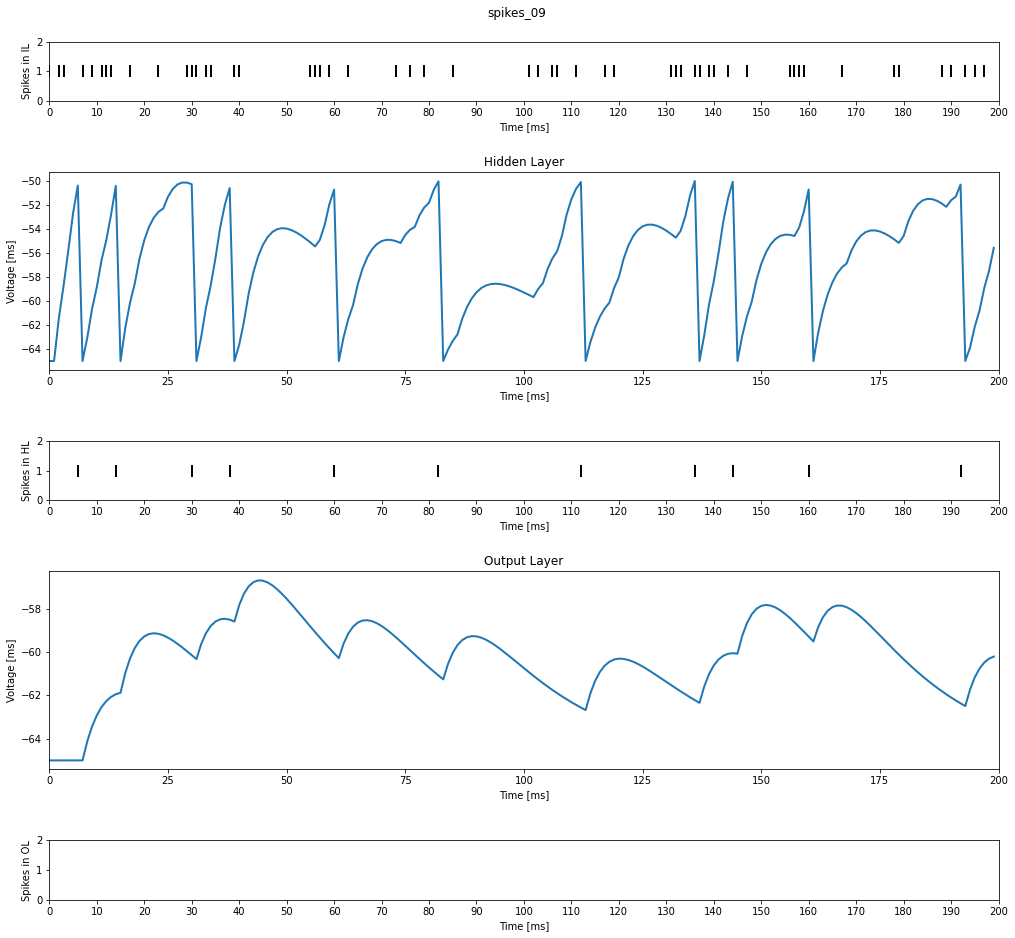

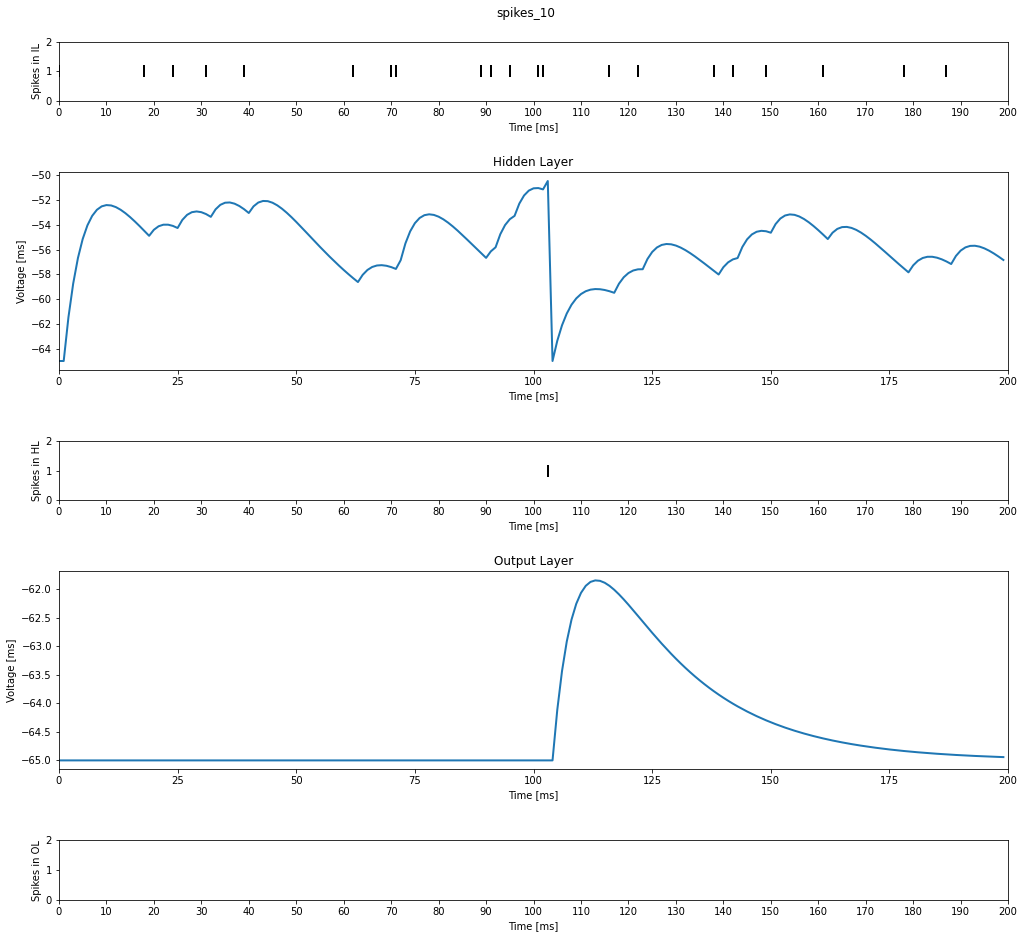

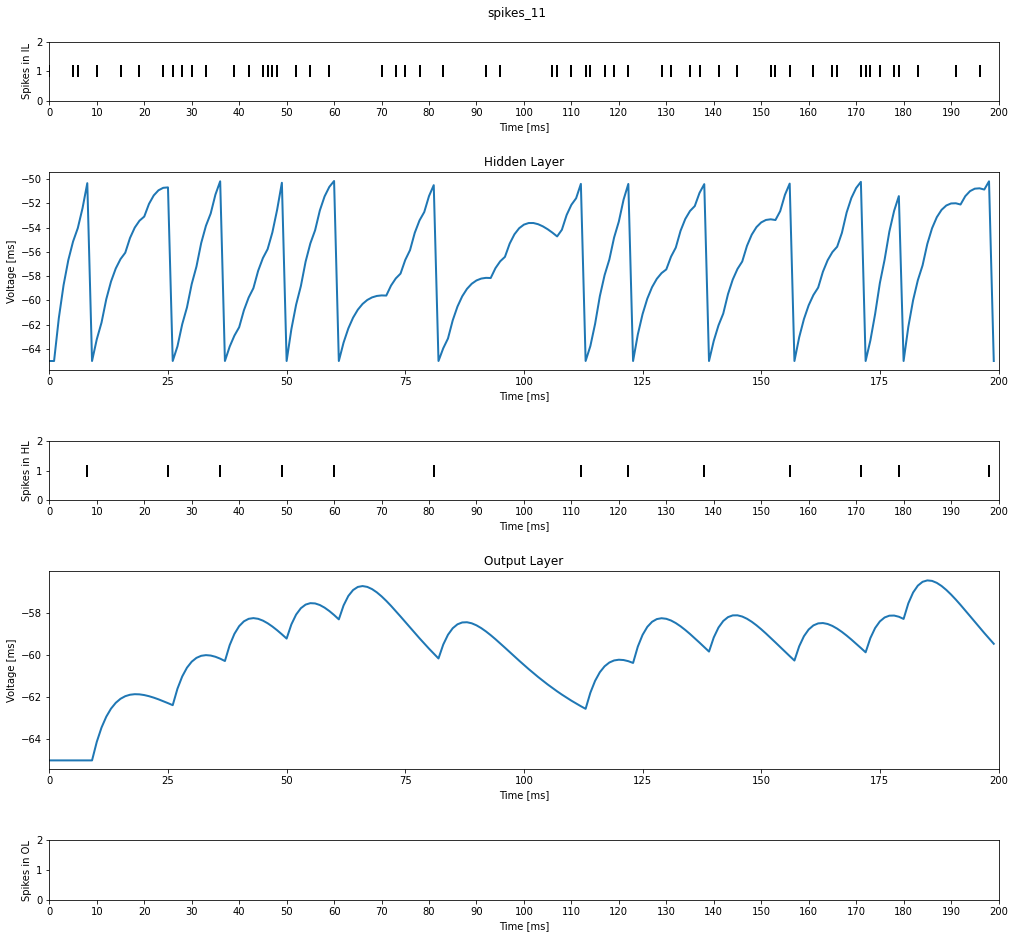

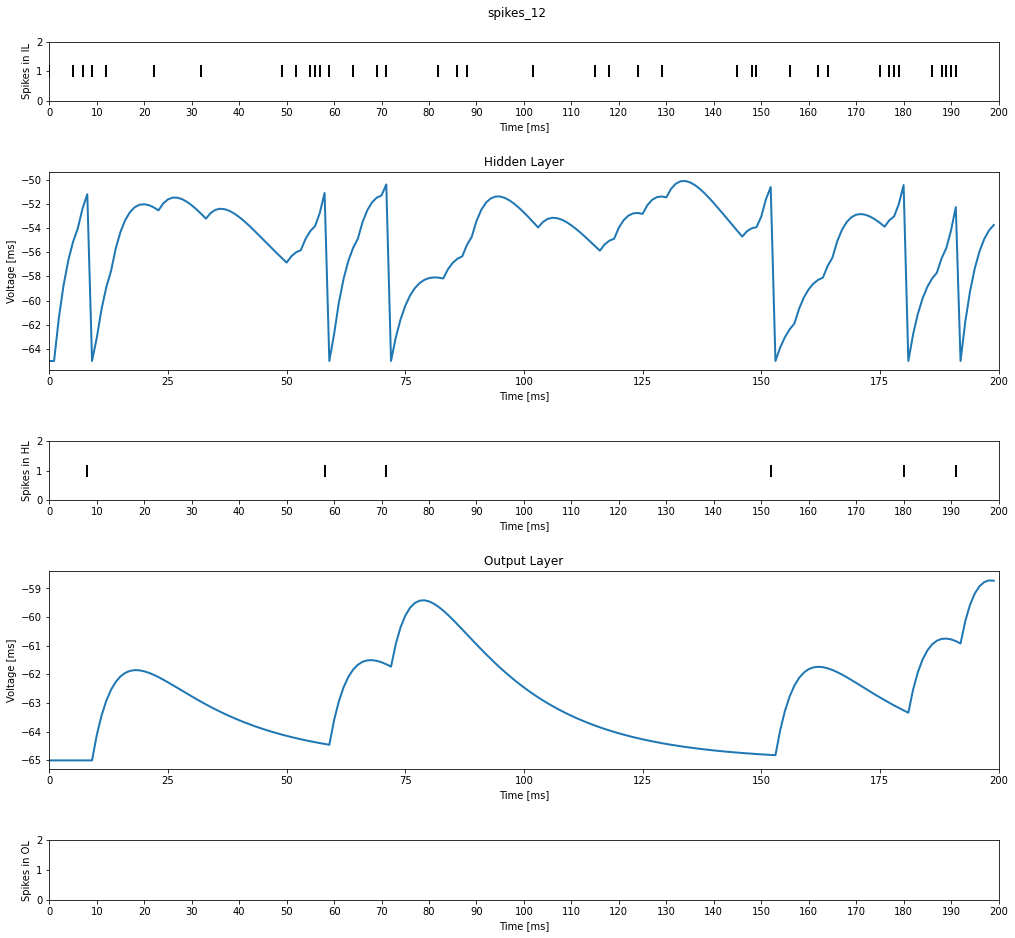

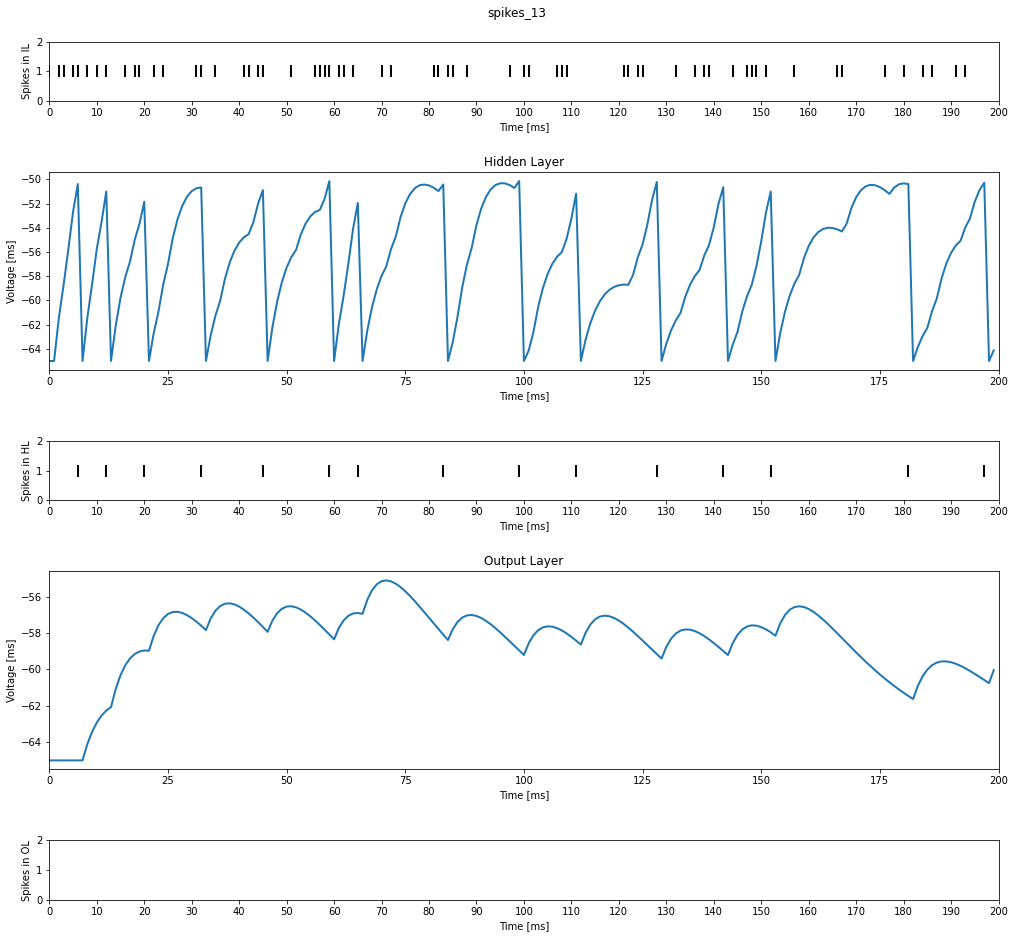

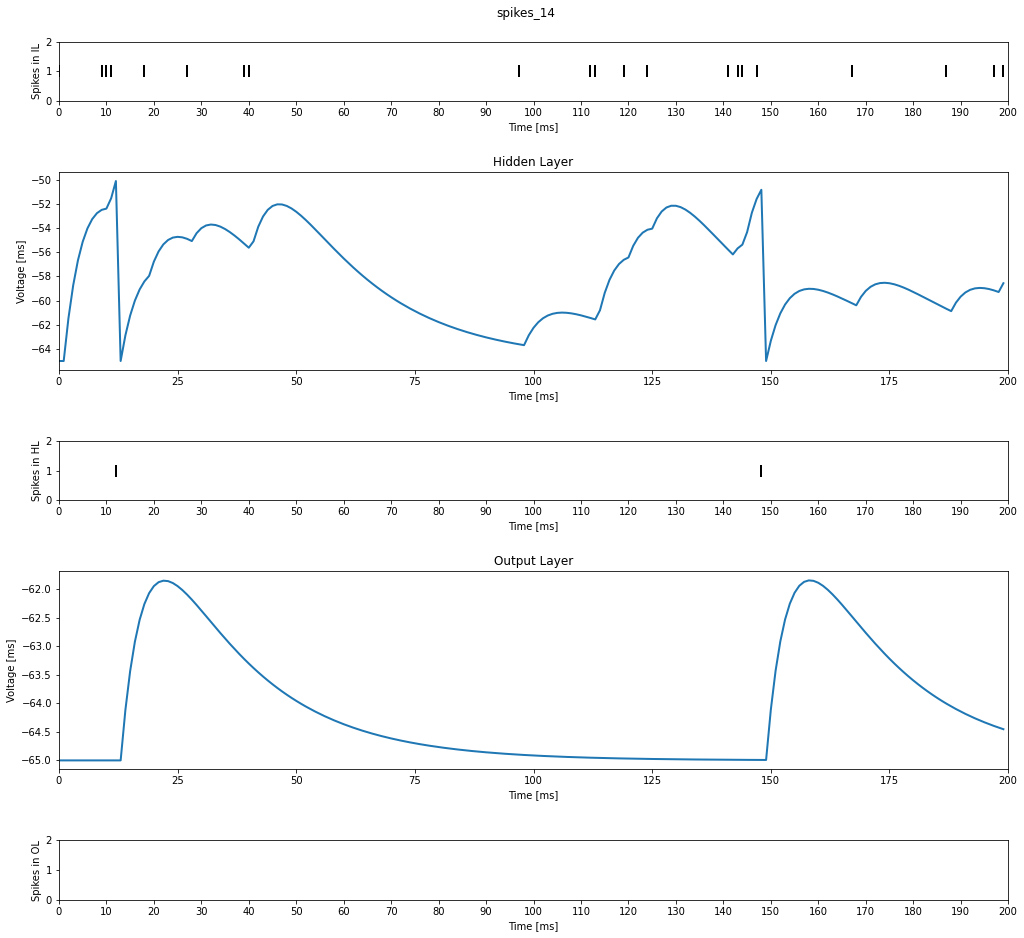

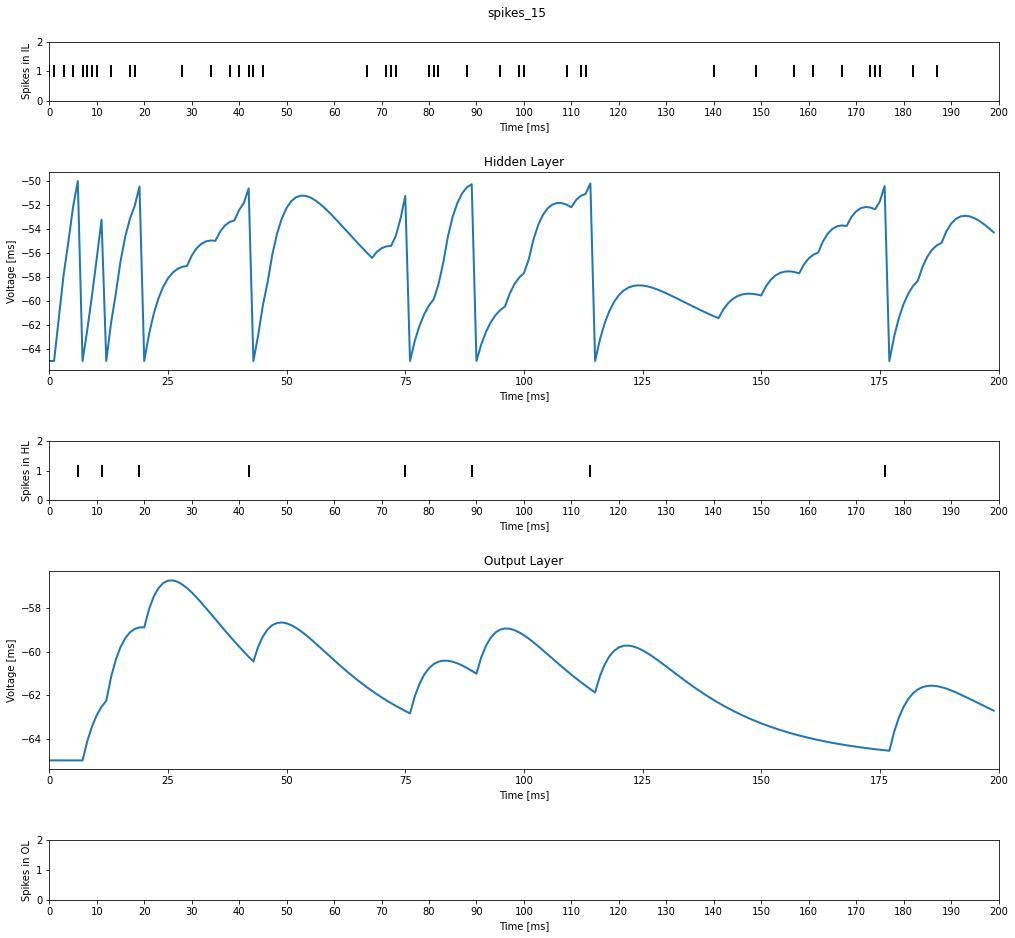

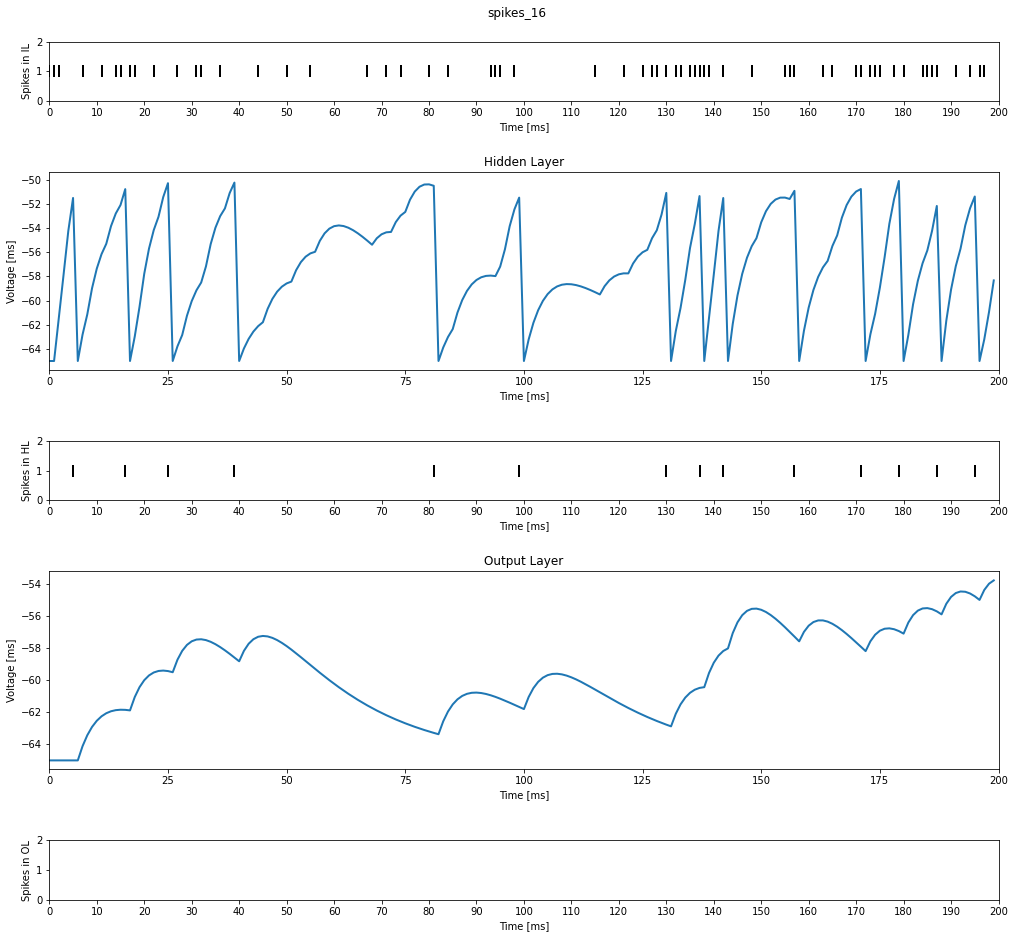

In [3]:
#SpiNNaker Setup
delay = 2*dt
nb_steps = 200


ratio = 1 
nb_hl = 1
nb_nol = 1
nb_nhl = 1
nb_nil = 1

# Fetch available trains of spikes in path
path = "input/"
files = fetch_files(path)

# Stack Spike Trains
n = len(files)
spike_trains = np.zeros((nb_steps,n))
for i in range(n):

    spike_trains[:,i] = genfromtxt(files[i], delimiter=',') 
    i_spikes = spike_trains[:,i:i+1]
    i_indexes = np.asarray(np.where(i_spikes>0)).reshape(-1)

    
    node_id = p.setup(timestep=dt, min_delay=delay, max_delay=delay)     
    p.set_number_of_neurons_per_core(p.IF_curr_exp, 10) #  100 neurons per core   

    # Create Populations
    celltype = p.IF_curr_exp

    fcnn_i = p.Population(nb_nil,p.SpikeSourceArray(spike_times=(i_indexes)))
    fcnn_h = p.Population(nb_nhl, celltype(**cell_params), label="fcnn_h")
    fcnn_o = p.Population(nb_nol, celltype(**cell_params), label="fcnn_o")



    # Setup Connectivity
    cell_conn = p.AllToAllConnector()
    connections = {'il_hl': p.Projection(fcnn_i, fcnn_h, cell_conn,
                            receptor_type='excitatory',
                            synapse_type=p.StaticSynapse(weight=w, delay=0)),
                   'hl_ol': p.Projection(fcnn_h, fcnn_o, cell_conn,
                            receptor_type='excitatory',
                            synapse_type=p.StaticSynapse(weight=w, delay=0))}

    # Record Voltages and Spikes
    fcnn_i.record(["spikes"])
    fcnn_h.record(["v","spikes"])
    fcnn_o.record(["v","spikes"])


    # Start Simulation
    print("%d Running simulation..." % node_id)
    p.run(nb_steps)

    # Get recorded data
    z_il = fcnn_i.get_data("spikes")
    v_hl = fcnn_h.get_data("v")
    z_hl = fcnn_h.get_data("spikes")
    v_ol = fcnn_o.get_data("v")
    z_ol = fcnn_o.get_data("spikes")

    # End Simulation

    p.end()

    time.sleep(20)

    i_indexes = np.asarray(z_il.segments[0].spiketrains[0])
    i_spikes = np.zeros((nb_steps,nb_nil))
    for j in i_indexes.astype(int):
        i_spikes[j,:] = 1

    v_hl = np.array(v_hl.segments[0].filter(name="v")[0]).reshape((nb_steps,nb_nhl))
    o_indexes_hl = np.asarray(z_hl.segments[0].spiketrains[0])
    o_spikes_hl = np.zeros((nb_steps,nb_nhl))
    for j in o_indexes_hl.astype(int):
        o_spikes_hl[j,:] = 1

    v_ol = np.array(v_ol.segments[0].filter(name="v")[0]).reshape((nb_steps,nb_nol))
    o_indexes_ol = np.asarray(z_ol.segments[0].spiketrains[0])
    o_spikes_ol = np.zeros((nb_steps,nb_nol))
    for j in o_indexes_ol.astype(int):
        o_spikes_ol[j,:] = 1

    
    sfn = files[i].replace("input/","").replace(".csv","")
    
    np.savetxt("summary/spinnaker/" + "voltage_hl_" + sfn, v_hl, delimiter=",")
    np.savetxt("summary/spinnaker/" + "output_hl_" + sfn, o_spikes_hl, delimiter=",")    
    np.savetxt("summary/spinnaker/" + "voltage_ol_" + sfn, v_ol, delimiter=",")
    np.savetxt("summary/spinnaker/" + "output_ol_" + sfn, o_spikes_ol, delimiter=",")
        
    # Plot Stuff
    plot_iho(i_spikes, o_spikes_hl, v_hl, o_spikes_ol, v_ol, sfn, nb_steps, ratio)    
